# **Проект "Телеком"**



## Описание задачи
Задача - научиться прогназировать отток клиентов из компании - мобильного оператора. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Оператором были собраны перрсональные данные о некторых клиенатах, информация об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Цель задачи:

Обучить модель которая бы предсказывала уйдёт клиент или нет. Метрика AUC-ROC не менее 0.75.

## План работы

*   Обзор задачи, постановка цели
*   Блок импорта библиотек
*   Загрузка и первичный обзор данных
*   Объединение таблиц
*   Обработка пропусков
*   Создание/удаление признаков
*   Исследование корреляции признаков
*   Разделение выборки на тестовую и тренеровочную
*   Кодировка признаков (One-hot)
*   Обучение моделей
*   Сравнение моделей
*   Финальная проверка на тестовой выборке
*   Анализ значимости признаков
*   Попытка улучшить качество модели на основе анализа значимости признаков



## Импорт библиотек

In [1]:
! pip install -q phik
! pip install -q catboost

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import cv, Pool

import phik
from phik.report import plot_correlation_matrix
from phik import report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка и первичный обзор данных

In [3]:
try:
  ! unzip -o /content/drive/MyDrive/Practicum_projects/Telecom/final_provider.zip
except:
  print('Error')

Archive:  /content/drive/MyDrive/Practicum_projects/Telecom/final_provider.zip
  inflating: final_provider/personal.csv  
  inflating: __MACOSX/final_provider/._personal.csv  
  inflating: final_provider/contract.csv  
  inflating: final_provider/phone.csv  
  inflating: __MACOSX/final_provider/._phone.csv  
  inflating: final_provider/internet.csv  


### Таблица contract

In [4]:
try:
  df_contract = pd.read_csv('/content/final_provider/contract.csv')
except:
  print('Error')

In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4274,3572-UUHRS,2016-05-01,No,One year,No,Bank transfer (automatic),18.85,867.3
739,7503-MIOGA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),89.85,6697.35
684,8040-MNRTF,2020-01-01,No,Month-to-month,No,Mailed check,71.10,71.1


In [7]:
df_contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [8]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Эти пользователи зарегистрировались в момент выгрузки таблиц из базы данных и ещё не успели заплатить. Изменим пробелы в столбце `TotalCharges` на `0` и приведём данные в столбце к типу `float` чтобы была возможность посмотреть на гистограмму.

In [9]:
df_contract.loc[df_contract['TotalCharges'] == ' ', 'TotalCharges'] = df_contract['MonthlyCharges']

In [10]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

In [11]:
df_contract['TotalCharges'].describe()

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

In [12]:
df_contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

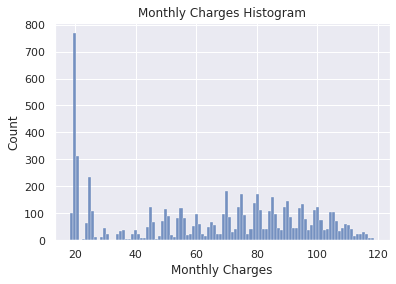

In [13]:
a = sns.histplot(df_contract, x='MonthlyCharges', bins=100)
a.set(xlabel='Monthly Charges', ylabel='Count', 
      title='Monthly Charges Histogram')
plt.show()

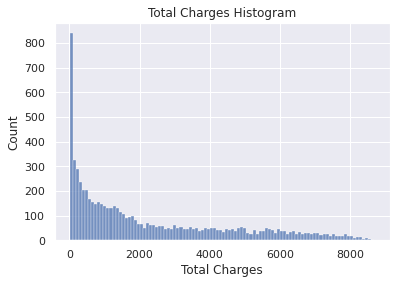

In [14]:
a = sns.histplot(df_contract, x='TotalCharges', bins=100)
a.set(xlabel='Total Charges', ylabel='Count', 
      title='Total Charges Histogram')
plt.show()

In [15]:
len(df_contract['customerID'].unique())

7043

In [16]:
df_contract.loc[df_contract['EndDate'] == 'No', 'EndDate'].count()/ df_contract['EndDate'].count()

0.7346301292063041

In [17]:
df_contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [18]:
df_contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [19]:
df_contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [20]:
df_contract['BeginDate'].min()

'2013-10-01'

In [21]:
df_contract[df_contract['EndDate'] != 'No']['EndDate'].min()

'2019-10-01 00:00:00'

In [22]:
df_contract[df_contract['EndDate'] != 'No']['EndDate'].max()

'2020-01-01 00:00:00'

#### Вывод

Это таблица с информацией о заключённых контрактах. В ней содержится 8 столбцов по 7043 строк в каждом, без пропусков (за исключением тех что мы уже обработали).


*   `customerID` - уникальный идентификатор пользователя, не повторяется, встречается во всех таблицах, пригодится для объединения. Удалить перед обучением меделей.
*   `BeginDate` - дата заключения контракта, есть у каждого клиента.
*   `EndDate` - дата прекращения действия контракта. У большинаства(73.5%) пользователей значение `No`. Если указана дата - значит пользователь ушёл. В соответствии с нашей задачей заменим на бинарный столбец Ушёл/Не ушёл.
*   `Type` - категориальный признак, содержит информацию о типах контрактов. Всего их три: с помесячной оплатой, на год, на два.
*   `PaperlessBilling` - бинарный признак. выставляются ли счета в бумажном виде или нет.
*   `PaymentMethod` - категориальный признак с информацией о способе оплаты, всего 4 способа.
*   `MonthlyCharges` - количественный признак с информацией о месячных затратах абонента.
*   `TotalCharges` - количественный признак с информацией о общих расходах абонента за весь период действия контракта.

При взгляде на гистограмму месячных затрат (`MonthlyCharges`) можно заметить, что распределение довольно равномерное, не считая резкого пика в  районе 19-20 долларов (очевидно, абоненты с минимальным пакетом услег). Также отчётливо видны пики, расположенные через равномерные промежутки в цене. Это может говорить о популярности определённых комплектов услуг среди абонентов. Средее не сильно отличается от медианы.

На гистограмме общих затрат (`TotalCharges`) отчётливо видно геометрическое распределение, что вполне очевидно: старых клиентов почти всегда меньше чем новых, соответственно тех, кто потратил немного денег за весь период своих отношений с компанией будет значительно больше. Среднее гораздо больше медианы.

Данные предоставлены с конца 2013 года, данные об ушедьших клиентах доступны за ноябрь-декабрь 2019 года.



### Таблица internet

In [23]:
try:
  df_internet = pd.read_csv('/content/final_provider/internet.csv')
except:
  print('Error')

In [24]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [25]:
df_internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
632,0229-LFJAF,DSL,Yes,Yes,Yes,Yes,No,No
3027,5299-SJCZT,Fiber optic,No,No,Yes,No,Yes,Yes
4728,7568-PODML,DSL,No,No,No,No,Yes,Yes


In [26]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [27]:
df_internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

#### Вывод

Это таблица с информацией об интернет услугах. В ней содержится 8 столбцов по 5517 строк в каждом, без пропусков.


*   `customerID` - уникальный идентификатор пользователя как и в предыдущей таблице.
*   `InternetService` - категориальный признак, 2 уникальных значения. Содержит информацию о том, какой тип подключения использует обонент. При дальнейшем объединении таблиц можно добавить третье значение `no_internet` для абонентов которые не пользуются интернетом.
*   `OnlineSecurity, OnlineBackup,
       DeviceProtection, TechSupport, StreamingTV, StreamingMovies` - бинарные столбцы, содержащие информацию о подключённых услугах.

В этой таблице на полторы тысячи записей меньше чем в таблице с контрактами. Не все люди пользуются интернетом.


### Таблица personal

In [28]:
try:
  df_personal = pd.read_csv('/content/final_provider/personal.csv')
except:
  print('Error')

In [29]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [30]:
df_personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
6652,0827-ITJPH,Male,0,No,No
5558,0675-NCDYU,Female,0,Yes,Yes
4488,3714-JTVOV,Female,1,Yes,No


In [31]:
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [32]:
df_personal['SeniorCitizen'].unique()

array([0, 1])

#### Вывод

Это таблица с информацией об абонентах. В ней содержится 5 столбцов по 7043 строк в каждом, без пропусков.


*   `customerID` - уникальный идентификатор пользователя как и в предыдущих таблицах.
*   `gender` - бинарный признак указывает на пол абонента.
*   `SeniorCitizen` - бинарный признак, указывает на наличие у абонента статуса пожилого.
*   `Partner` - бинарный признак, указывает на наличие у абонента партнёра.
*   `Dependents` - бинарный признак, указывает на наличие у абонента иждивенцев.

Количество записей в этой таблице совпадает с количеством записей в таблице с контрактами, значит для каждого контракта найдётся свой абонент. Часть бинарных признаков записана в формате `0, 1`, часть в формате `Yes, No`, в итоговой таблице нужно будет привести их к единому виду.

### Таблица phone

In [33]:
try:
  df_phone = pd.read_csv('/content/final_provider/phone.csv')
except:
  print('Error')

In [34]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [35]:
df_phone.sample(3)

,customerID,MultipleLines
5363,4786-UKSNZ,No
1508,8189-HBVRW,Yes
4487,6413-XKKPU,No


#### Вывод

Это таблица с информацией о телефонных услугах. В ней содержится 2 столбца по 6361 строк в каждом, без пропусков.


*   `customerID` - уникальный идентификатор пользователя как и в предыдущих таблицах.
*   `MultipleLines` - бинарный признак, отражает наличие услуги по подключению телефона к нескольким линиям одновременно.

Количество абонентов использующих телефон меньше общего количества абонентов, телефон используют не все абоненты. На этапе объединения таблиц сделаем из бинарного `MultipleLines` категориальный признак и добавить третье уникальное значение `no_phone`.

## Обработка и объединение таблиц

Для каждой таблицы приведём названия столбцов к формату "snake". Затем переведём значения всех бинарных признаков в `True/False`. Для этого для начала заменим значения на `1/0`, а затем применим `.astype('bool')` и займёмся остальной необходимой оброботкой.

### Обработка contract

In [36]:
df_contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [37]:
df_contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']

Создадим колонку с целевым признаком

In [38]:
df_contract.loc[df_contract['end_date'] != 'No', 'left'] = 1
df_contract['left'] = df_contract['left'].fillna(0)

Посчитаем сколько дней каждый абонент является клиентом компании на момент выгрузки датасета

In [39]:
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d %H:%M:%S')

df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')

In [40]:
df_contract['loyalty'] = df_contract['end_date'] - df_contract['begin_date']

In [41]:
def days(td):
    return td.days

In [42]:
df_contract['loyalty'] = df_contract['loyalty'].apply(days)

In [43]:
df_contract = df_contract.drop(['begin_date', 'end_date'], axis=1)

In [44]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 440.3+ KB


In [45]:
df_contract.sample(3)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,left,loyalty
1126,0927-LCSMG,Month-to-month,No,Mailed check,74.65,544.55,1.0,214
3231,9938-EKRGF,Month-to-month,No,Mailed check,84.45,1287.85,0.0,457
611,4765-OXPPD,Month-to-month,No,Mailed check,65.00,663.05,1.0,273


### Обработка internet

In [46]:
df_internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [47]:
df_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [48]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [49]:
df_internet.sample(3)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
2772,6212-ATMLK,Fiber optic,No,No,No,No,Yes,Yes
2938,1816-FLZDK,DSL,No,No,No,Yes,No,No
1640,9919-FZDED,DSL,Yes,Yes,Yes,No,Yes,Yes


### Обработка personal

In [50]:
df_personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [51]:
df_personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [52]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [53]:
df_personal.sample(3)

,customer_id,gender,senior_citizen,partner,dependents
4551,5827-MWCZK,Male,0,Yes,Yes
1934,4587-NUKOX,Female,0,No,No
3012,2160-GPFXD,Male,0,Yes,Yes


### Обработка phone

In [54]:
df_phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [55]:
df_phone.columns = ['customer_id', 'multiple_lines']

In [56]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [57]:
df_phone.sample(3)

,customer_id,multiple_lines
643,7929-DMBCV,No
5796,7921-BEPCI,Yes
3608,3692-JHONH,Yes


### Объединение

Объединим все таблицы с помощью ключевого значения колонки `customer_id`, пропуски в данных заполним в соответствии выводами из первичного обзора данных

In [58]:
df = df_contract.merge(df_personal, on='customer_id', how='left')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 715.3+ KB


In [60]:
df = df.merge(df_phone, on='customer_id', how='left')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 770.3+ KB


In [62]:
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

In [63]:
df = df.merge(df_internet, on='customer_id', how='left')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

In [65]:
df.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,left,loyalty,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31,Female,0,Yes,No,no_phone,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0.0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371,Male,0,No,No,no_phone,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [66]:
df['internet_service'] = df['internet_service'].fillna('no_internet')

In [67]:
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [68]:
df_internet.describe()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [69]:
for i in ['online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']:
       df[i] = df[i].fillna('No')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   left               7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

In [71]:
df.sample(5)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,left,loyalty,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
3007,6022-UGGSO,Month-to-month,Yes,Electronic check,74.40,2276.95,1.0,975,Female,1,No,No,No,Fiber optic,No,Yes,No,No,No,No
1225,6581-NQCBA,Month-to-month,Yes,Electronic check,49.95,810.20,1.0,488,Female,0,Yes,No,no_phone,DSL,No,No,No,Yes,Yes,Yes
3150,6029-CSMJE,Month-to-month,Yes,Mailed check,25.65,440.20,0.0,518,Male,0,No,No,no_phone,DSL,No,No,No,No,No,No
4422,6874-SGLHU,One year,Yes,Bank transfer (automatic),97.00,3021.30,0.0,914,Male,0,No,No,No,Fiber optic,No,Yes,No,No,Yes,Yes
6891,7853-OETYL,Month-to-month,Yes,Electronic check,29.05,129.60,0.0,123,Female,0,Yes,No,no_phone,DSL,Yes,No,No,No,No,No


Удалим customer_id, после объединения этот признак будет только мешать обучению моделей.

In [72]:
df = df.drop('customer_id', axis=1)

## Исследование корреляции данных

In [73]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'left', 'loyalty', 'senior_citizen']


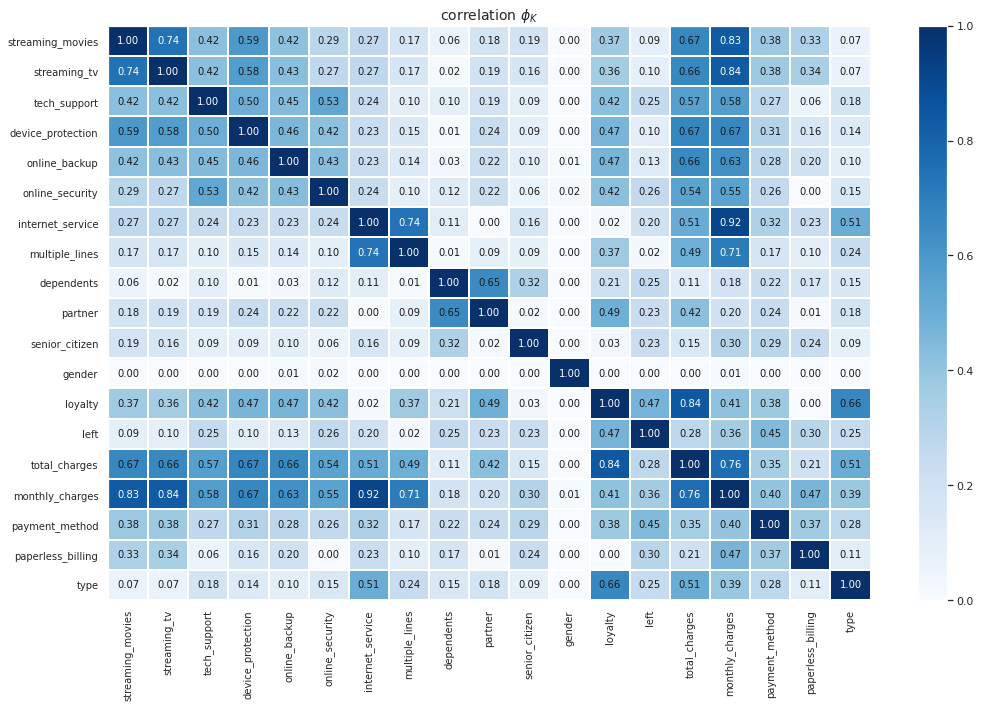

In [74]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.0, 
                        figsize=(15, 10))
plt.tight_layout()

### Вывод
Очень сильно `monthly_charges` зависит от ряда интернет-услуг, особенно от `streaming_tv`, `streaming_movies`, заметно, что они созависимы(очевидно, при стриминге фильмов обычно комплектом стриминг тв) с показателем корреляции 0.74, правильным решением будет удалить один столбец. Удалим `streaming_tv`

### Внесение изменений в соответствии с выводом

In [75]:
df = df.drop('streaming_tv', axis=1)

## Разделение на тренеровочную и тестовую

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('left', axis=1), df.left, test_size=0.25, random_state=171022)

## Кодировка признаков

In [77]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_movies']

In [78]:
ohe_enc = OneHotEncoder(drop = 'first')

In [79]:
ohe_enc.fit(X_train[cat_features])

OneHotEncoder(drop='first')

In [80]:
new_columns = ohe_enc.get_feature_names(cat_features)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Кодировка тренировочной выборки

In [81]:
X_train_ohe = pd.DataFrame(ohe_enc.transform(X_train[cat_features]).toarray(), columns = new_columns).reset_index(drop=True)

In [82]:
X_train_enc = X_train.drop(cat_features, axis=1).reset_index(drop=True)

In [83]:
X_train_enc = X_train_enc.join(X_train_ohe)

In [84]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         5282 non-null   float64
 1   total_charges                           5282 non-null   float64
 2   loyalty                                 5282 non-null   int64  
 3   senior_citizen                          5282 non-null   int64  
 4   type_One year                           5282 non-null   float64
 5   type_Two year                           5282 non-null   float64
 6   paperless_billing_Yes                   5282 non-null   float64
 7   payment_method_Credit card (automatic)  5282 non-null   float64
 8   payment_method_Electronic check         5282 non-null   float64
 9   payment_method_Mailed check             5282 non-null   float64
 10  gender_Male                             5282 non-null   floa

### Кодировка тестовой выборки

In [85]:
X_test_ohe = pd.DataFrame(ohe_enc.transform(X_test[cat_features]).toarray(), columns = new_columns).reset_index(drop=True)

In [86]:
X_test_enc = X_test.drop(cat_features, axis=1).reset_index(drop=True)

In [87]:
X_test_enc = X_test_enc.join(X_test_ohe)

In [88]:
X_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         1761 non-null   float64
 1   total_charges                           1761 non-null   float64
 2   loyalty                                 1761 non-null   int64  
 3   senior_citizen                          1761 non-null   int64  
 4   type_One year                           1761 non-null   float64
 5   type_Two year                           1761 non-null   float64
 6   paperless_billing_Yes                   1761 non-null   float64
 7   payment_method_Credit card (automatic)  1761 non-null   float64
 8   payment_method_Electronic check         1761 non-null   float64
 9   payment_method_Mailed check             1761 non-null   float64
 10  gender_Male                             1761 non-null   floa

### Вывод
Мы успешно закодировали признаки методом `one-hot encoding`

## Обучение моделей

Обучим модели случайного леса и градиентного бустинга и посмотрим на их результаты (roc-auc) на кросс-валидации

### Random Forest Classifier

In [89]:
clf_forest = RandomForestClassifier(random_state=171022)
parametrs_forest = {'n_estimators': range (1, 20, 5), 'max_depth': range (1, 8, 1)}
grid_forest = GridSearchCV(clf_forest, parametrs_forest, cv=5, verbose=1, n_jobs=-1, scoring='roc_auc')
grid_forest.fit(X_train_enc, y_train)
grid_forest.best_params_
print('Лучший средний roc-auc на обучающей выборке:', round(grid_forest.best_score_, 2), ', для модели с параметрами:', grid_forest.best_params_)


Fitting 5 folds for each of 28 candidates, totalling 140 fits
Лучший средний roc-auc на обучающей выборке: 0.85 , для модели с параметрами: {'max_depth': 6, 'n_estimators': 16}


### CatBoost

In [90]:
params = {
'loss_function' : 'Logloss',
'custom_loss' : 'AUC:hints=skip_train~false',
'eval_metric' : 'AUC:hints=skip_train~false',
'verbose' : 200,
'random_seed' : 171022,
'cat_features' : cat_features
}

In [91]:
model = CatBoostClassifier(**params)

In [92]:
grid = {'learning_rate': [0.01, 0.1, 0.4], 'depth': [1, 4, 50], }

In [93]:
grid_search_result = model.grid_search(grid, X=X_train, y=y_train)

0:	learn: 0.6609121	test: 0.6681350	best: 0.6681350 (0)	total: 53.8ms	remaining: 53.7s
200:	learn: 0.8406407	test: 0.8436740	best: 0.8438178 (197)	total: 1.39s	remaining: 5.54s
400:	learn: 0.8480529	test: 0.8474016	best: 0.8474387 (375)	total: 2.83s	remaining: 4.23s
600:	learn: 0.8522749	test: 0.8504519	best: 0.8504843 (598)	total: 3.92s	remaining: 2.6s
800:	learn: 0.8552799	test: 0.8527181	best: 0.8528201 (793)	total: 4.85s	remaining: 1.21s
999:	learn: 0.8582794	test: 0.8550284	best: 0.8550284 (999)	total: 5.7s	remaining: 0us

bestTest = 0.8550283917
bestIteration = 999

0:	loss: 0.8550284	best: 0.8550284 (0)	total: 5.76s	remaining: 46.1s
0:	learn: 0.6609121	test: 0.6681350	best: 0.6681350 (0)	total: 4.04ms	remaining: 4.03s
200:	learn: 0.8636261	test: 0.8586585	best: 0.8588348 (198)	total: 923ms	remaining: 3.67s
400:	learn: 0.8696053	test: 0.8631353	best: 0.8631353 (400)	total: 2.13s	remaining: 3.18s
600:	learn: 0.8738154	test: 0.8654851	best: 0.8656335 (594)	total: 3.09s	remaining: 2

In [94]:
model.get_params()

{'loss_function': 'Logloss',
 'random_seed': 171022,
 'verbose': 200,
 'custom_loss': 'AUC:hints=skip_train~false',
 'eval_metric': 'AUC:hints=skip_train~false',
 'cat_features': ['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'partner',
  'dependents',
  'multiple_lines',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_movies'],
 'depth': 4,
 'learning_rate': 0.4}

In [95]:
max(grid_search_result['cv_results']['test-AUC-mean'])

0.9034533555038023

### Вывод
Сat Boost показал результат `AUC-ROC` в `0.90` , в то время как случайный лес `0.85`. Выбираем Cat Boost и проверим качество модели на тестовой выборке.

## Проверка модели на тестовой выборке

In [96]:
params = {
'loss_function' : 'Logloss',
'custom_loss' : 'AUC:hints=skip_train~false',
'eval_metric' : 'AUC:hints=skip_train~false',
'verbose' : 200,
'random_seed' : 171022,
'learning_rate': 0.12, 
'depth': 4,
'iterations': 1000,
'cat_features' : cat_features
}

In [97]:
model = CatBoostClassifier(**params)

In [98]:
model.fit(X_train, y_train, verbose=10)

0:	learn: 0.7983081	total: 5.16ms	remaining: 5.15s
10:	learn: 0.8520559	total: 57.1ms	remaining: 5.13s
20:	learn: 0.8647475	total: 107ms	remaining: 4.97s
30:	learn: 0.8738882	total: 156ms	remaining: 4.88s
40:	learn: 0.8777273	total: 208ms	remaining: 4.87s
50:	learn: 0.8807184	total: 257ms	remaining: 4.78s
60:	learn: 0.8854717	total: 304ms	remaining: 4.68s
70:	learn: 0.8874383	total: 354ms	remaining: 4.63s
80:	learn: 0.8908011	total: 402ms	remaining: 4.56s
90:	learn: 0.8939913	total: 454ms	remaining: 4.54s
100:	learn: 0.8971144	total: 505ms	remaining: 4.49s
110:	learn: 0.9015594	total: 558ms	remaining: 4.47s
120:	learn: 0.9061947	total: 608ms	remaining: 4.42s
130:	learn: 0.9089844	total: 669ms	remaining: 4.44s
140:	learn: 0.9121019	total: 719ms	remaining: 4.38s
150:	learn: 0.9146031	total: 770ms	remaining: 4.33s
160:	learn: 0.9181387	total: 822ms	remaining: 4.28s
170:	learn: 0.9196972	total: 875ms	remaining: 4.24s
180:	learn: 0.9221920	total: 926ms	remaining: 4.19s
190:	learn: 0.9238392

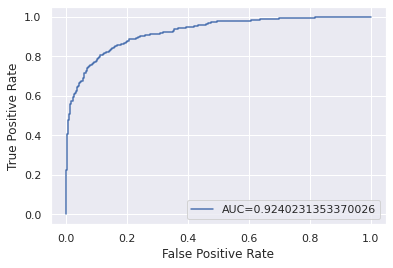


Значение метрики ROC-AUC на тестовой выборке: 0.92402
Значение метрики Accuracy на тестовой выборке: 0.88018


In [99]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
final_roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(final_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print('')
print('Значение метрики ROC-AUC на тестовой выборке:', round(final_roc_auc, 5))
final_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
print('Значение метрики Accuracy на тестовой выборке:', round(final_accuracy, 5))

## Анализ значимости признаков

In [100]:
df_importance = {'feature': X_test.columns, 'importance': model.get_feature_importance()}
df_importance = pd.DataFrame(data=df_importance).sort_values(by='importance', ascending= False)
df_importance

,feature,importance
5,loyalty,56.416009
3,monthly_charges,11.573712
4,total_charges,10.079284
0,type,6.513554
11,internet_service,3.227057
2,payment_method,2.697286
10,multiple_lines,2.208928
1,paperless_billing,1.120432
6,gender,1.087121
15,tech_support,1.012856


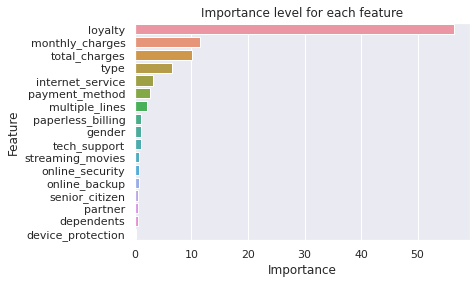

In [101]:
a = sns.barplot(x="importance", y="feature", data=df_importance)
a.set(xlabel='Importance', ylabel='Feature', 
      title='Importance level for each feature')
plt.show()

## Промежуточный вывод

Для предсказания оттока клиентов было решено взять две модели Random Forest и Catboost, сравнить их результаты на кросс-валидации, определить лучшую модель и её оптимальный гиперпараметры и проверить её качество уже на тестовой выборке.

Сравнение осуществляли по метрике ROC-AUC. Модель случайного леса показала результат `0.85`, в то время как Catboost - `0.9`. Для финальной проверки мы взяли модель Catboost с гиперпараметрами: ` 'depth': 4, 'learning_rate': 0.1 `, которые подобрали в процессе кросс-валидации, остальные гиперпараметры оставили значениями по умолчанию.

В результате на тестовой выборке модель показала значение метрики ROC-AUC: `0.92252`, вспомогательная метрика Accuracy на тестовой выборке: `0.88132`.

После получения результатов мы вывели диаграмму и значения значимости признаков. Заметно, что наибольшее значение для модели имеет признак `loyalty` со значением `55.8`, в этом признаке мы хранили информацию о том, сколько времени клиент пробыл с нами до своего ухода, либо, в случае если он не ушёл, на момент выгрузки данных. Значительно менее значимые признаки, но всё же выбивающиеся из остальных значений - `type: 6.595549`, `monthly_charges:	11.725656`, `total_charges:	10.220329`. Это признаки с типом контракта и числовые: с месячной платой и с суммой потраченной абонентом за всё время пользования услугами.

## Отчёт о проделанной работе
### План
Работа велась в соответствии с планом. Некоторые изменения, например, добавление новых признаков или изменение типа данных делались по ходу работы так как того требовали дальнейшие действия.
### Затруднения
Значительных затруднений в процессе работы не возникло.
### Ключевые шаги
Основными шагами, позволившими достичь высокого значения целевой метрики являлись: предобработка и объединение таблиц, заполнение пропусков в итоговом датафрейме и выбор модели Catboost.
### Модель
Модель выбиралась из двух претендентов: случайный лес и градиентный бустинг. Был проведён подбор гиперпараметров моделей и проверка кросс-валидацией в результате которой лучше всего себя показала модель градиентного бустинга Catboost с гиперпараметрами: `depth: 4, learning_rate: 0.1`. Также модели были переданы все категориальные признаки списком `cat_features`, остальные гиперпараметры оставили по умолчанию.
### Признаки
При обучении модели использовались все параметры практически без изменений. Все таблицы были слиты в одну, был получен целевой признак `left` по принципу "если ест дата окончания договора - значит клиент ушёл, нет - нет", вычеслено и выделено в отдельный признак `loyalty` количество дней, которые абонент провёл в качестве клиента компании до своего ухода, либо на момент выгрузки данных из базы данных, столбцы с датами были удалены за ненадобностью и во избежание созданию помех для обучения. После исследования корреляций был удалён принак `streaming_tv`, он был сильно связан с признаком `streaming_movies`, он мог бы испортить итоговое качество модели.

Список признаков, которые использовались для обучения: `type, paperless_billing, payment_method, monthly_charges,
       total_charges, loyalty, gender, senior_citizen, partner,
       dependents, multiple_lines, internet_service, online_security,
       online_backup, device_protection, tech_support,
       streaming_movies`
### Предобработка
Предобработка данных заключалась в основном в обработке пропусков, возникших вследствие слияния таблиц. Пропуски после слияния данных об абонентах и контрактах с данными об интеренет-услугах мы запонили значением `no_internet` для одного категориального признака и `No`, для остальных бинарных. Логично, ведь если человек не пользуется интернетом, что обязательно нужно отметить, он не пользуется и ни одной из представленных услуг. Таким же образом после этого мы поступили с таблицей о телефонных услугах. Ещё один момент, связвнный с предобработкой данных возник в самом начале: из-за того, что в значении `TotalCharges` имелись значения с пробелом колонка приобрела строковый тип данных, это было обнаружено на этапе исследования таблицы `contract` из-за ошибки при применении к таблице метода `.describe`. При взгляде на данные о договорах с этими абонентами стало ясно, что это люди, которые только-только заключили договор и ещё не успели заплаить за свой первый месяц (данные не успели обновиться), поэтому данные с пробелов были заменены на занчения из колонки `MonthlyCharges`, потому что подразумевается, что абоненты платят деньги за месяц вперёд.